- Author: https://github.com/muz-rdm

## Executive Summary

### Objective
- To have a deeper data understanding by conducting Exploratory Data Analysis (EDA).

### Summary
- Checked correlations: Extracted features that are highly correlated with reservation cancelations.
- Conducted descriptive analysis to better understand the underlying situations and issues.
- Summarized insights and conclusions.

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', None)

## Load Data

In [2]:
# Load dataset from csv file
df = pd.read_csv('../data/hotel_bookings_v1.csv')
df.shape

(119194, 34)

## Check Correlation between Columns (Continuous Variables)

In [3]:
# Compute correlation
df_corr = df.drop('agent', axis=1) # 'agent' is ID, not numerically meaningful

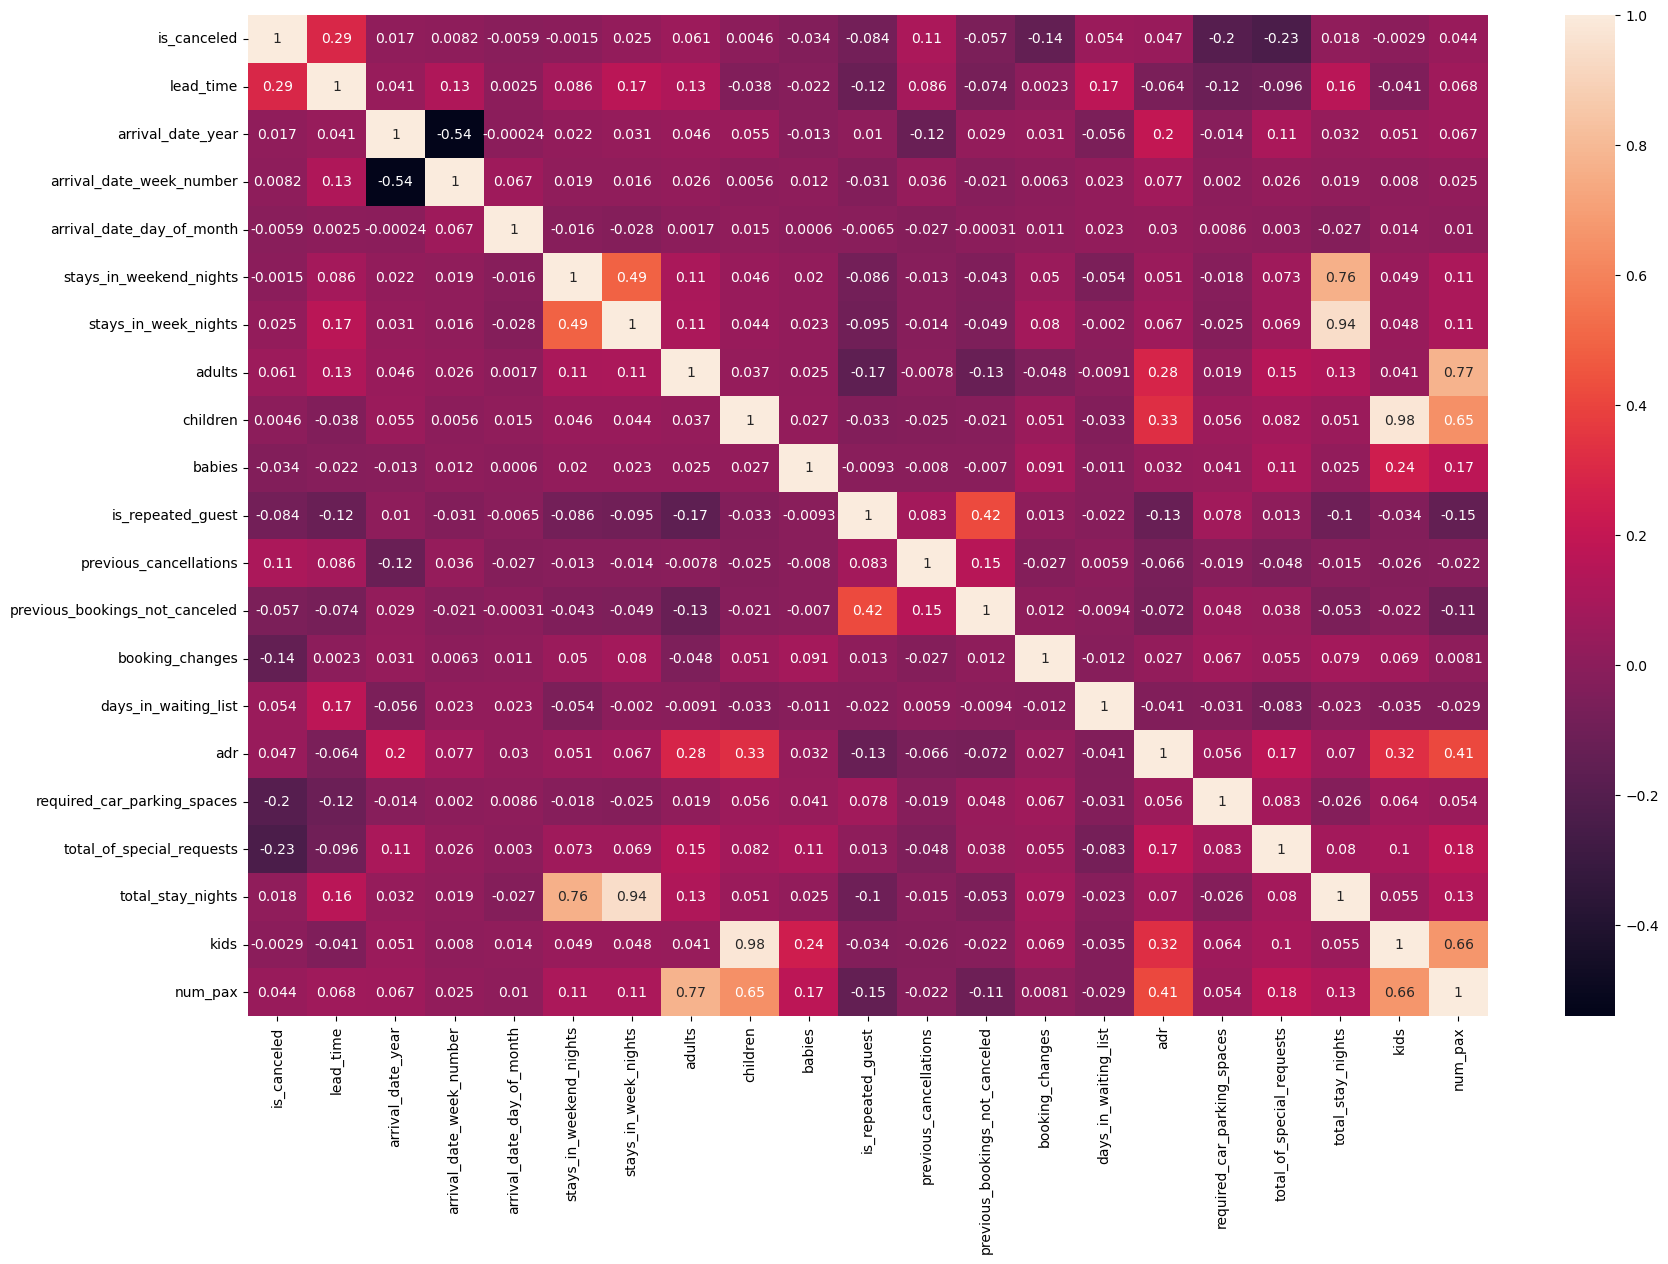

In [4]:
# Plot the heatmap to see correlation with columns
fig, ax = plt.subplots(figsize=(20,13))
sns.heatmap(df_corr.corr(), annot=True, ax=ax);

In [5]:
# Calculate correlation matrix
corr_matrix = df_corr.corr()

# Unstack correlation matrix
corr_values = corr_matrix.unstack()

# Create a DataFrame from the unstacked correlation matrix
corr_df = pd.DataFrame(corr_values, columns=['correlation'])

# Reset the index to create two columns for feature1 and feature2
corr_df = corr_df.reset_index()
corr_df = corr_df.rename(columns={'level_0':'feature1','level_1':'feature2'})

# Add absolute correlation values
corr_df['abs_correlation'] = abs(corr_df['correlation'])

# Sort the correlation values
corr_df = corr_df.sort_values(by='abs_correlation', ascending=False)
corr_df = corr_df[corr_df['feature1']!=corr_df['feature2']]
corr_df = corr_df[corr_df['feature1']=='is_canceled']
corr_df = corr_df.reset_index(drop=True)
corr_df

,feature1,feature2,correlation,abs_correlation
0,is_canceled,lead_time,0.292621,0.292621
1,is_canceled,total_of_special_requests,-0.234786,0.234786
2,is_canceled,required_car_parking_spaces,-0.195680,0.195680
3,is_canceled,booking_changes,-0.144807,0.144807
4,is_canceled,previous_cancellations,0.110170,0.110170
5,is_canceled,is_repeated_guest,-0.083724,0.083724
6,is_canceled,adults,0.060928,0.060928
7,is_canceled,previous_bookings_not_canceled,-0.057356,0.057356
8,is_canceled,days_in_waiting_list,0.054331,0.054331
9,is_canceled,adr,0.046864,0.046864


### Findings
- Customers who have higher lead time (make reservations very early before staying date) are more likely to cancel reservations.
- Customers who tends to cancel reservations are those who made lesser special request, required lesser parking spaces and made lesser changes to their reservations. 
- Customers who have higher number of cancellations for their previous reservations are more likely to cancel their new reservations.

### List of Top 5 Features that have high correlation with 'is_canceled'

In [6]:
# Feature with corr value more than 0.1
corr_df[corr_df['abs_correlation']>0.1]['feature2'].to_list()

['lead_time',
 'total_of_special_requests',
 'required_car_parking_spaces',
 'booking_changes',
 'previous_cancellations']

# Exploratory Data Analysis

## 1. Hotel Room Occupancy

### What is the occupancy (room days) over the past years?

In [7]:
# Add a new column for the number of days (occupancy)
df['total_stays_days'] = df['total_stay_nights'] + 1

In [8]:
# Create a new column for arrival date
df['arrival_datetime'] = pd.to_datetime(df['arrival_date_year'].astype(str)+'-'+
                                        df['arrival_date_month'].astype(str)+'-'+
                                        df['arrival_date_day_of_month'].astype(str))

In [9]:
# Create arrival day name
df['arrival_day_name'] = df['arrival_datetime'].dt.day_name()

In [10]:
# Create weekday/weekend label for arrival date
df['weekday_weekend'] = df['arrival_datetime'].dt.weekday.apply(lambda x: 'weekend' if x>=5 else 'weekday')

In [11]:
# Create a new column called 'month_year' that contains the month-year of the arrival_datetime
df['month_year'] = df['arrival_datetime'].dt.strftime('%Y-%m')

In [12]:
df['reservation_status'].value_counts()

Check-Out    75011
Canceled     42977
No-Show       1206
Name: reservation_status, dtype: int64

In [13]:
# Filter occupancy data
df_checkout = df[df['reservation_status']=='Check-Out']

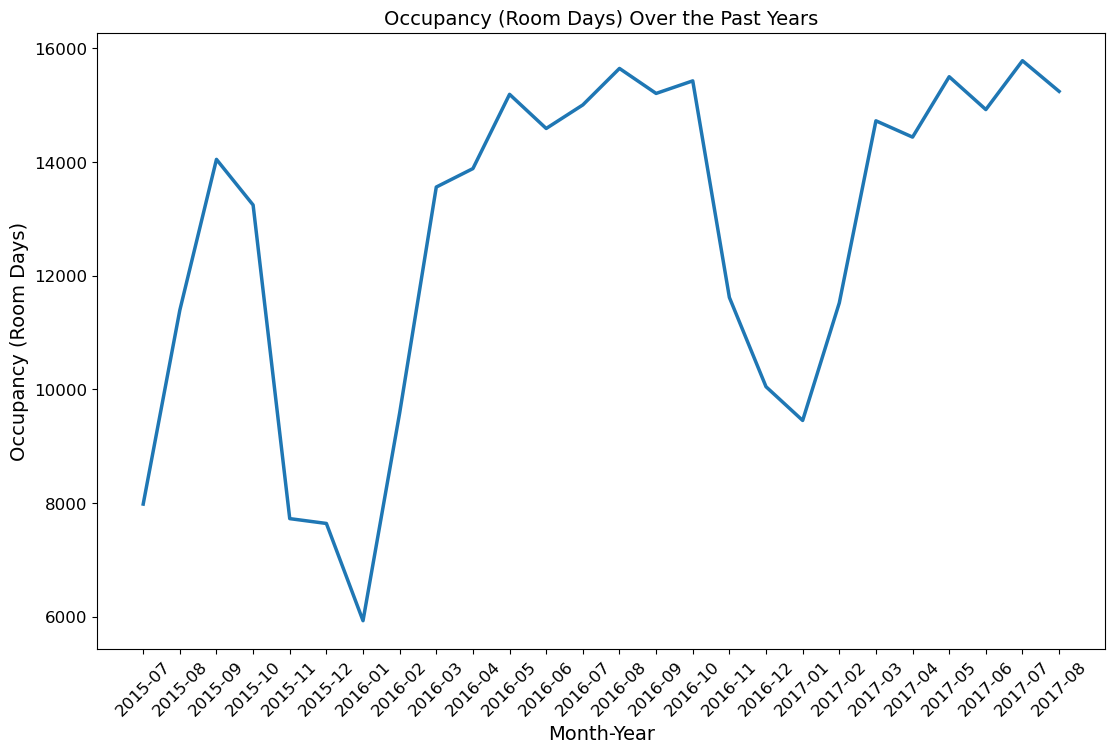

In [14]:
# Group the data by the 'month_year' column and calculate the sum of stays_in_week_days
monthly_stays = df_checkout.groupby('month_year')['total_stays_days'].sum()

# Plot
plt.figure(figsize=(13,8))
sns.lineplot(data=monthly_stays, linewidth=2.5)

# Format
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Occupancy (Room Days)', fontsize=14)
plt.title('Occupancy (Room Days) Over the Past Years', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

#### Findings
- Total monthly bookings peak at September/October.
- There are sharp drop of total monthly bookings between September/October and January.
- Need to check seasonality, however, more data might be required.

### What is the occupancy (room days) by Features?
- Hotel Type
- Market Segment
- Customer Type
- Room Type
- Arrival Day Type (Weekday or Weekend)
- Arrival Day Name

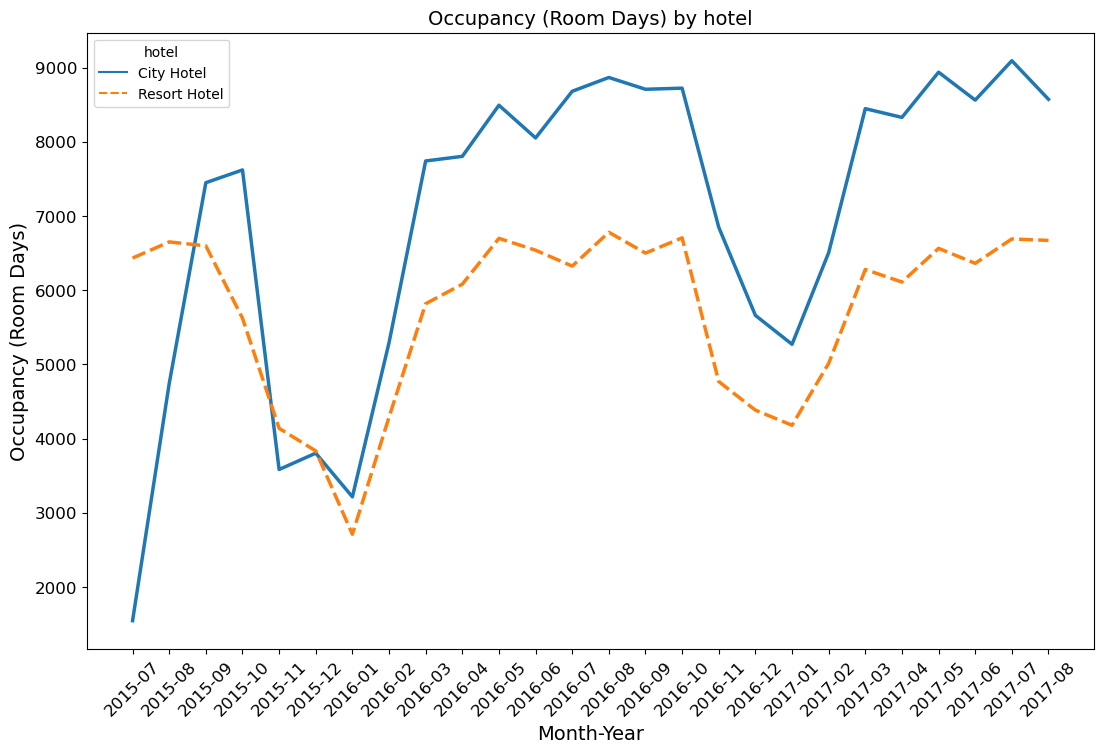

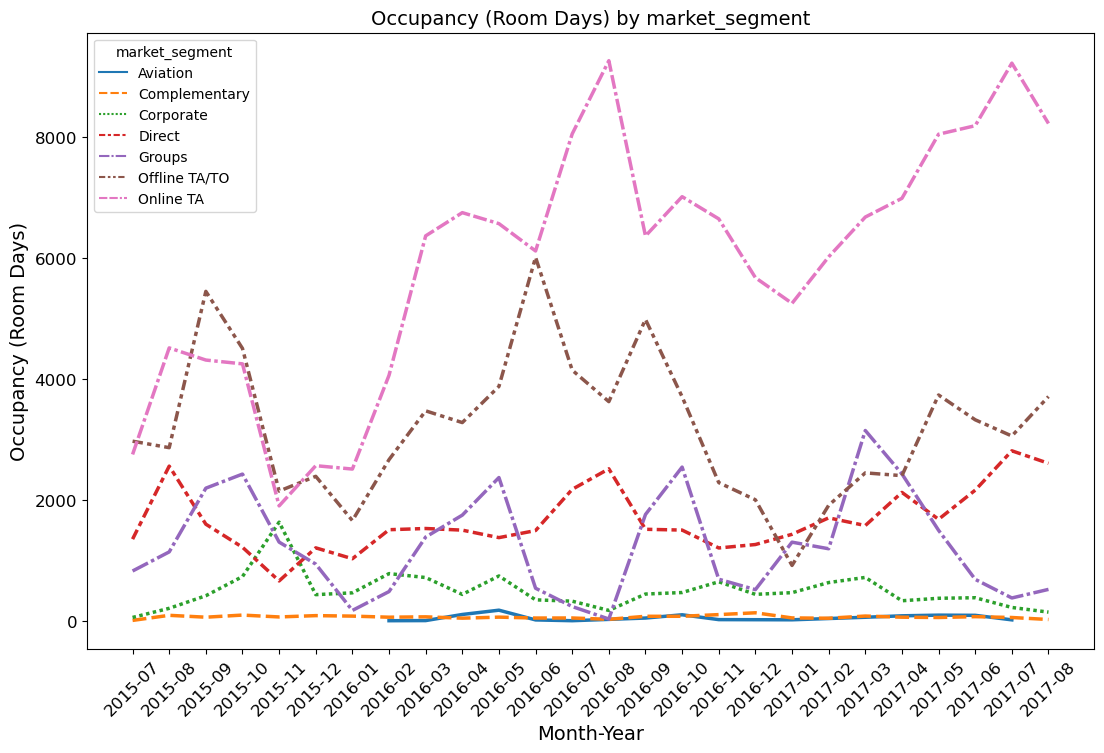

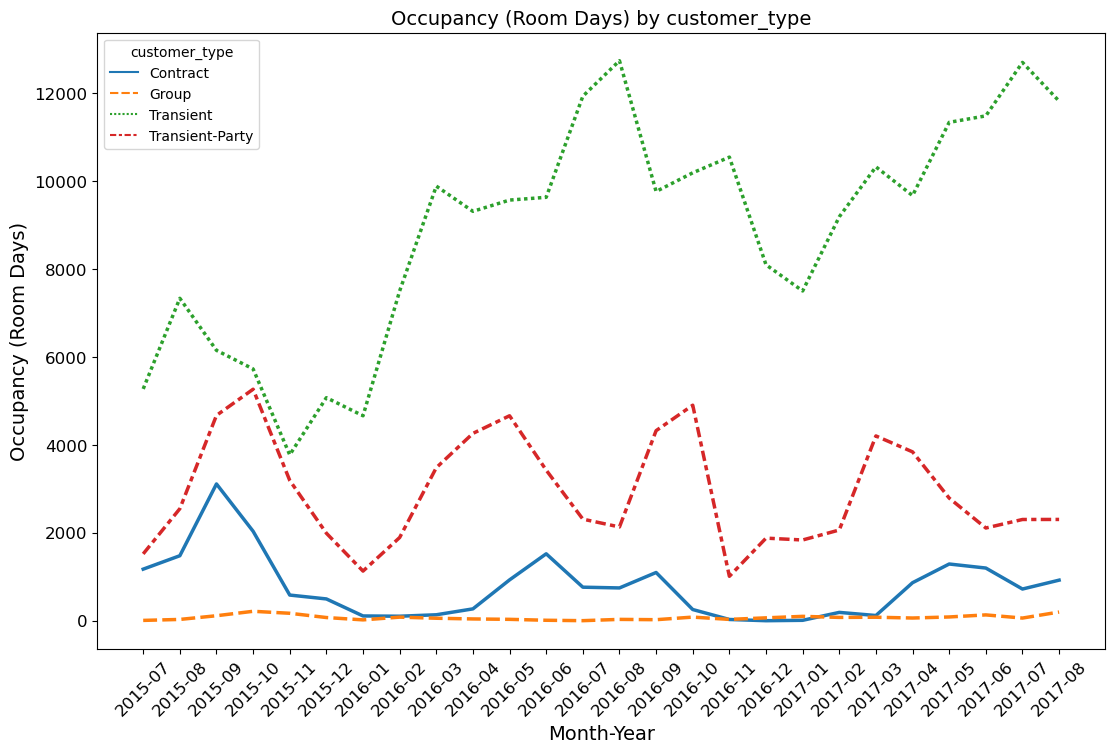

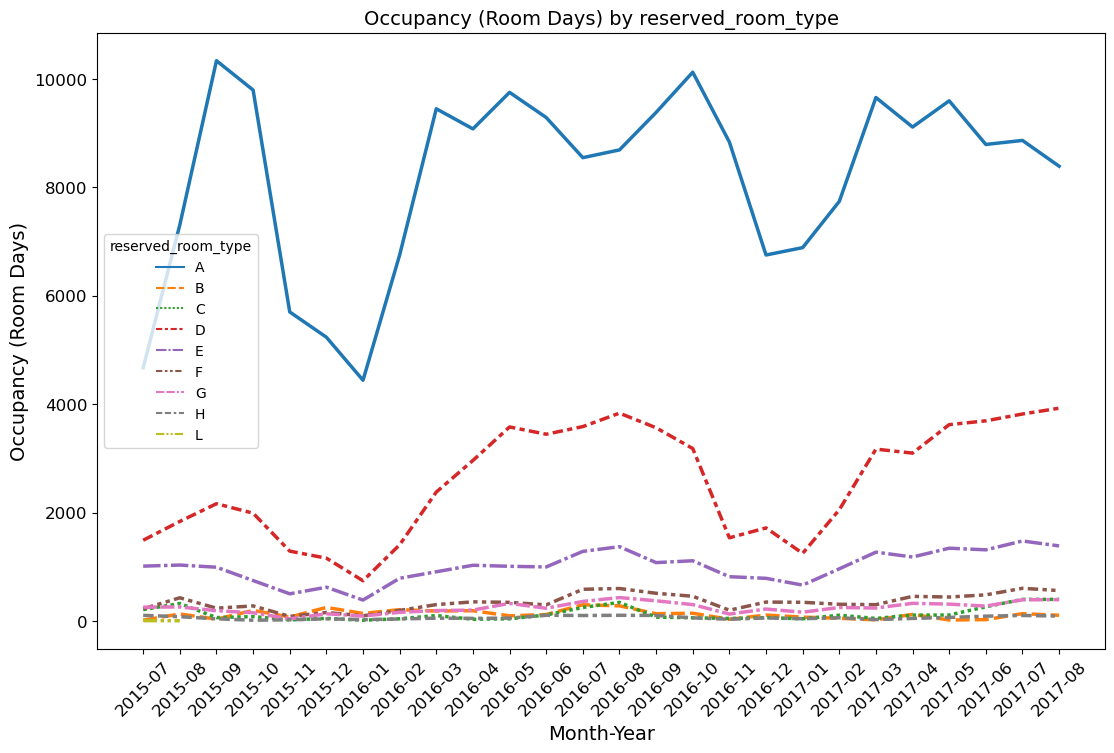

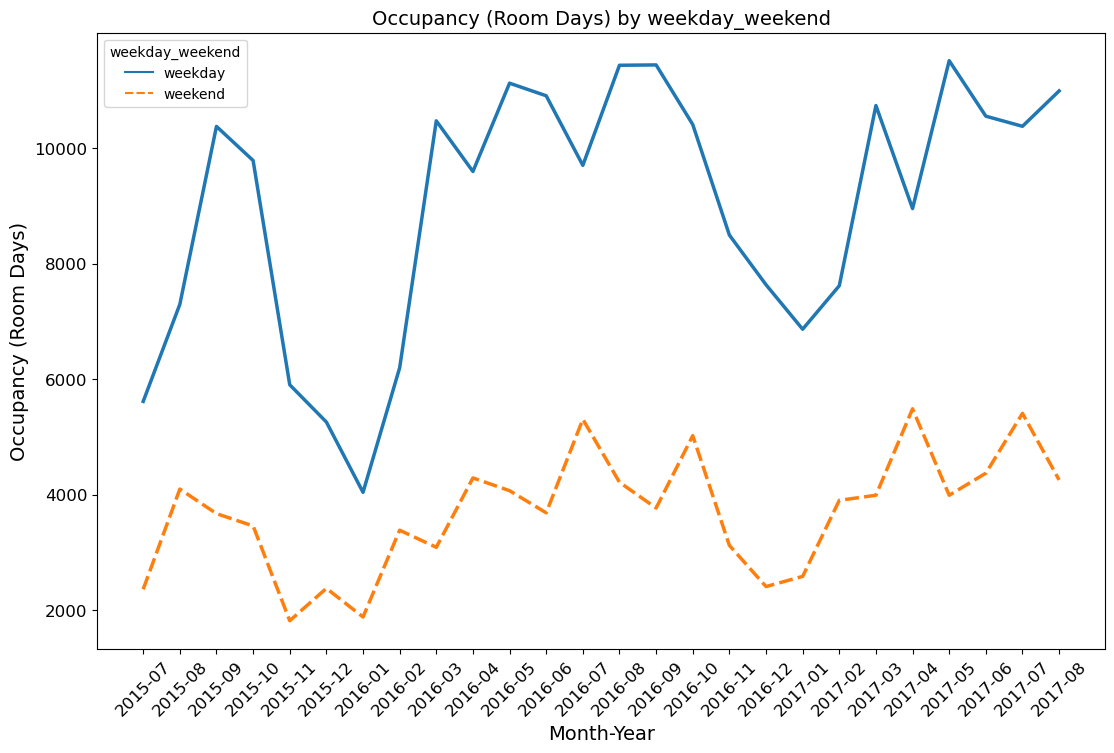

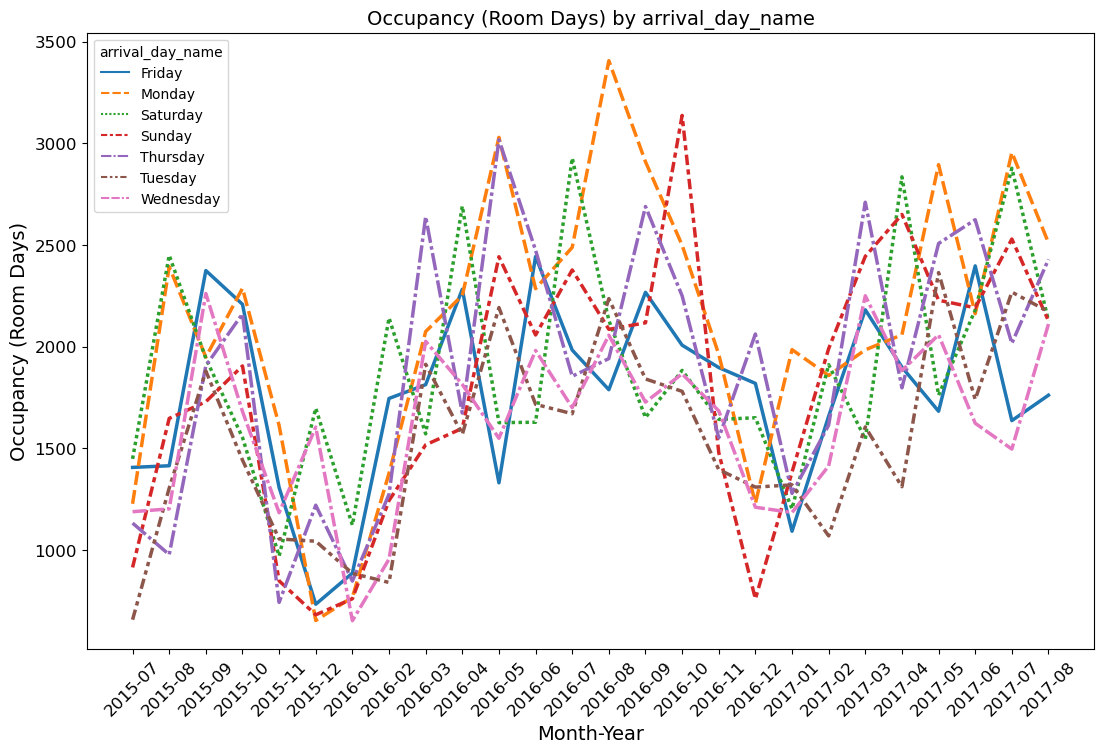

In [15]:
features = ['hotel', 'market_segment', 'customer_type', 'reserved_room_type', 'weekday_weekend', 'arrival_day_name']

for feat in features:
    # Group the data by the 'month_year' column and calculate the sum of stays_in_week_days
    monthly_stays_hotel = df_checkout.groupby(['month_year', feat])['total_stays_days'].sum().unstack()
    
    # Plot
    plt.figure(figsize=(13,8))
    sns.lineplot(data=monthly_stays_hotel, linewidth=2.5)
    
    # Format
    plt.xlabel('Month-Year', fontsize=14)
    plt.ylabel('Occupancy (Room Days)', fontsize=14)
    plt.title(f'Occupancy (Room Days) by {feat}', fontsize=14)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.show()

#### Findings
- The occupancy in both hotel types is gaining traction, with increasing demands over time, despite seasonal fluctuations.
- Customer from Online T/A segment is getting popular.
- Transient customers type is increasing rapidly.
- Room type A has the highest and growing demands, almost following the transient customers trends.
- Arrival during weekday (weekday stays) have more demands than weekend arrival stays.
- The occupancy based on arrival day name does not show too large discrepancy, which is a good signal for daily checkin/room distributions.

## 2. Reservation Cancellations

### Total Number of Confirmed/Canceled Reservations vs. Cancellation Rate

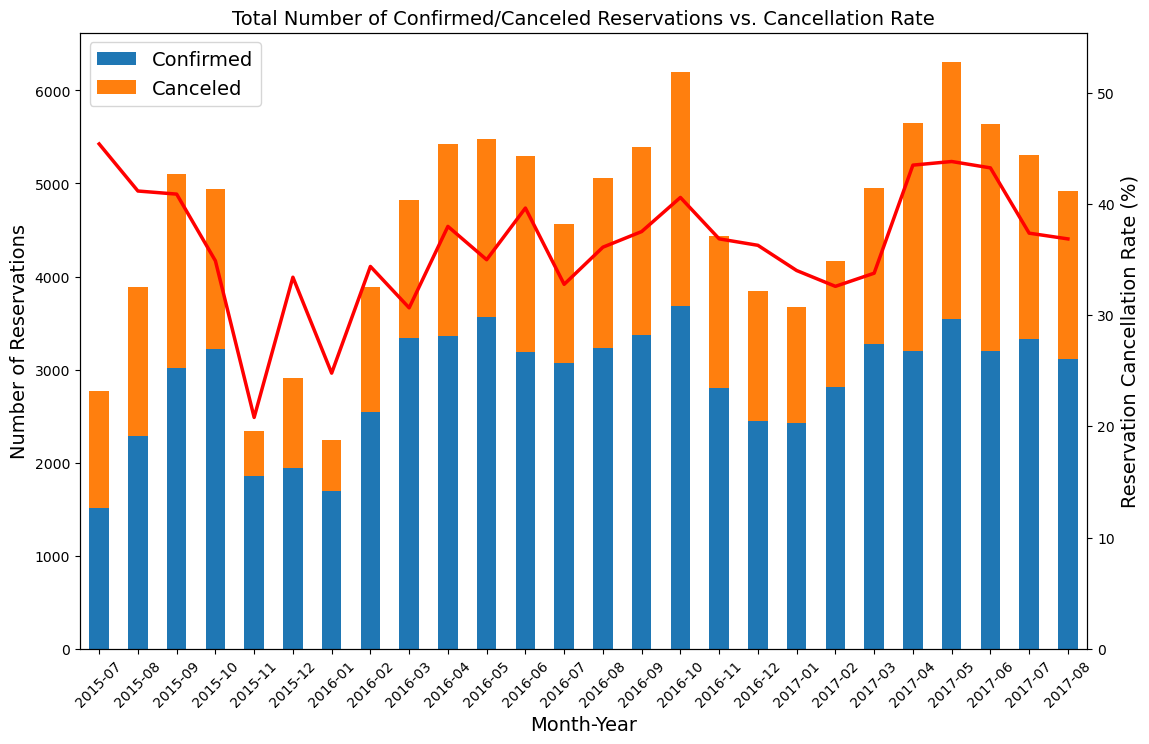

In [16]:
# Compute number of confirmed and canceled reservation
confirmed = df[df['is_canceled']==0].groupby(['month_year'])['is_canceled'].size()
canceled = df[df['is_canceled']==1].groupby(['month_year'])['is_canceled'].size()

# Combine the two series into a single dataframe
df_reservations = pd.DataFrame({'Confirmed': confirmed, 'Canceled': canceled})

# Compute reservations cancellation rate
cancel_rate = (df[df['is_canceled']==1].groupby('month_year').size()) / (df.groupby('month_year').size()) * 100

# Create the figure and the axes
fig, ax1 = plt.subplots(figsize=(13,8))

# Plot the stacked barplot on the first axis
df_reservations.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_xlabel('Month-Year', fontsize=14)
ax1.set_ylabel('Number of Reservations', fontsize=14)
ax1.set_title('Total Number of Confirmed/Canceled Reservations vs. Cancellation Rate', fontsize=14)
ax1.set_xticklabels(df_reservations.index, rotation=45)
ax1.legend(fontsize=14)

# Create a second y-axis with the cancellation rate
ax2 = ax1.twinx()
sns.lineplot(data=cancel_rate, linewidth=2.5, ax=ax2, color='r')
ax2.set_ylabel('Reservation Cancellation Rate (%)', fontsize=14)
ax2.set_ylim(0, max(cancel_rate) + 10)
plt.show()

#### Findings
- The percentage of canceled reservations (orange bar) follows a similar pattern as the overall number of bookings (orange + blue bar). 
- Other than period between 2015-07 and 2015-08, the cancellation rate also follows almost similar pattern of number of reservations.
- Reducing cancellation rate is important to increase sales, since there is signal of growing demands.

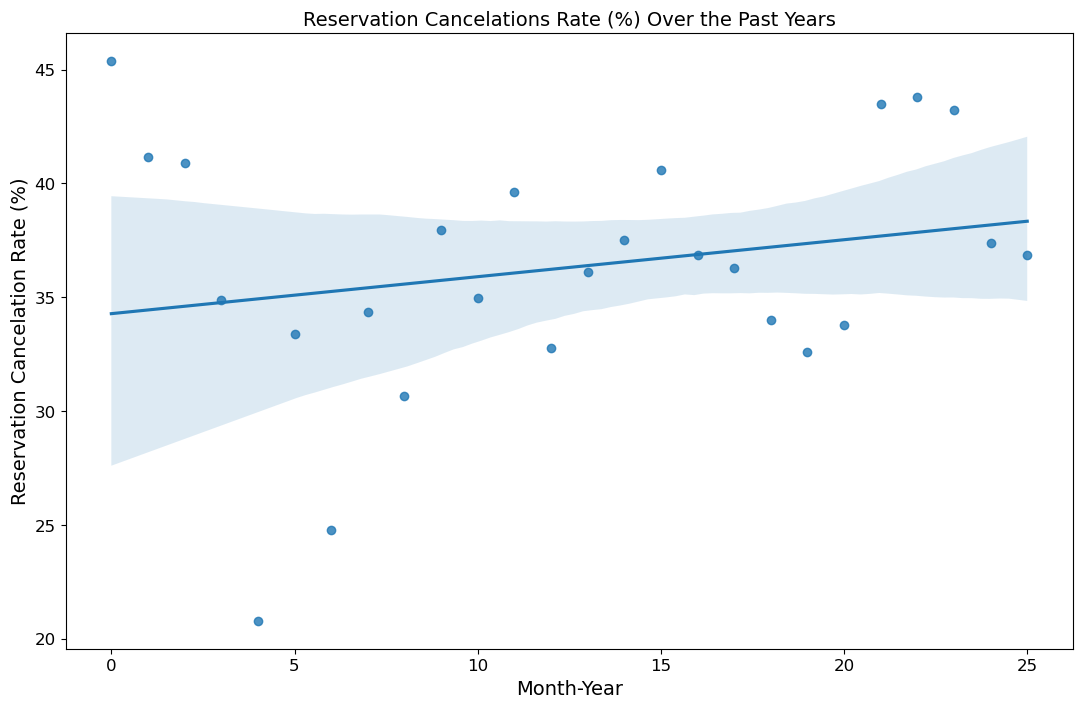

In [17]:
# Compute reservation cancelations rate
cancel_rate = (df[df['is_canceled']==1].groupby('month_year').size()) / (df.groupby('month_year').size()) * 100

df_cancel_rate = pd.DataFrame(cancel_rate).reset_index()
df_cancel_rate = df_cancel_rate.rename(columns={'index': 'month_year', 0: 'cancellation_rate'})

# Plot
plt.figure(figsize=(13,8))
sns.regplot(x=df_cancel_rate.index, y='cancellation_rate', data=df_cancel_rate)

# Format
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Reservation Cancelation Rate (%)', fontsize=14)
plt.title('Reservation Cancelations Rate (%) Over the Past Years', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#### Findings
- Monthly cancelation rate is increasing over time. 
- Last minute cancelation is a loss to business sides if there were no new reservations/on site reservation, meanwhile earlier cancelation may still give ample time to allow new reservations to be made by other customers.
- Cancelation due to plan change is somehow unavoidable, however, cancelation due to competitor hotels or users preference related cancelation can be avoided with right strategies. For example:

# What kind of reservations were cancelled?
- Trip type (Family (With kids)/Non Family)
- Room type
- Lead time
- Deposit type

In [18]:
df['lead_time'].describe()

count    119194.000000
mean        104.077898
std         106.848301
min           0.000000
25%          18.000000
50%          69.000000
75%         160.000000
max         737.000000
Name: lead_time, dtype: float64

In [19]:
df = df.assign(lead_time_level = lambda x: np.where(x['lead_time'] <= 18, 'very_low',
                                                      np.where((x['lead_time'] > 18) & (x['lead_time'] <= 69), 'low',
                                                               np.where((x['lead_time'] > 69) & (x['lead_time'] <= 160), 'high',
                                                                        np.where(x['lead_time'] > 160, 'very_high', np.nan)))))

In [20]:
# Create a new column 'family' with a default value of 0
df['family'] = 0

# Check if the 'children' or 'babies' columns are not equal to 0 or not null
# If true, update the 'family' column to 1
df.loc[(df['children'] != 0) | (df['babies'] != 0), 'family'] = 1

Factor:  hotel 
 City Hotel      74.9
Resort Hotel    25.1
Name: hotel, dtype: float64 



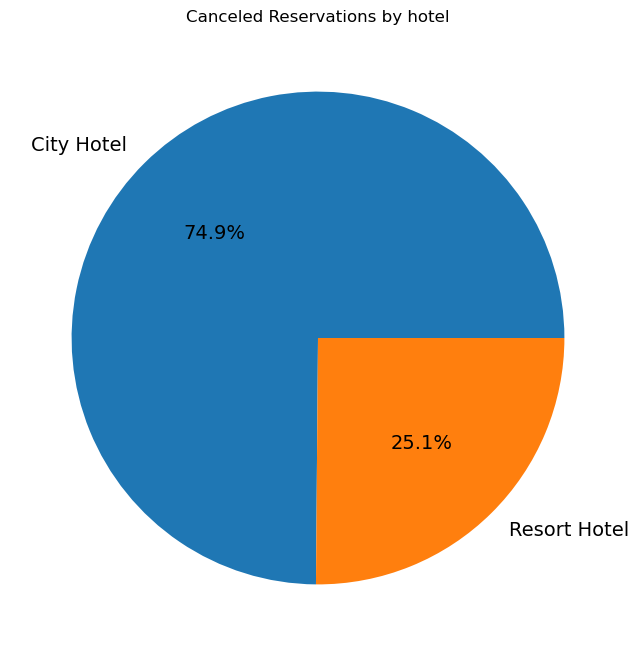

Factor:  family 
 0    92.6
1     7.4
Name: family, dtype: float64 



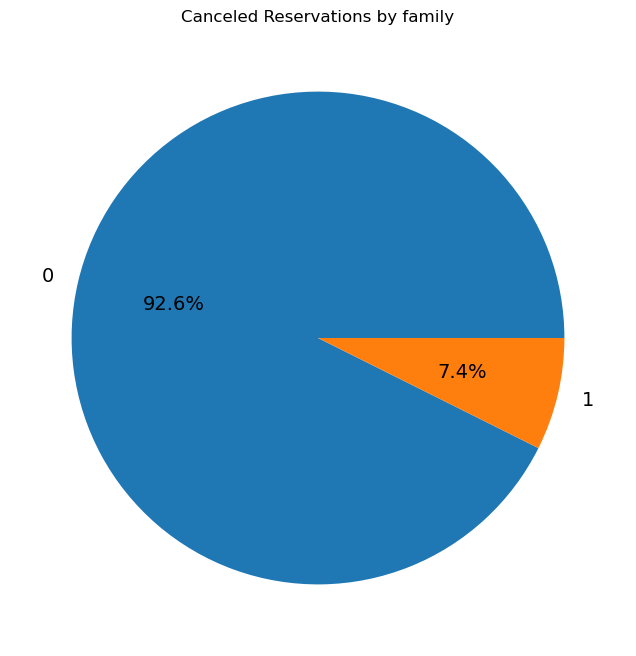

Factor:  reserved_room_type 
 A    76.1
D    13.8
E     4.3
F     2.0
G     1.7
B     0.8
C     0.7
H     0.6
L     0.0
Name: reserved_room_type, dtype: float64 



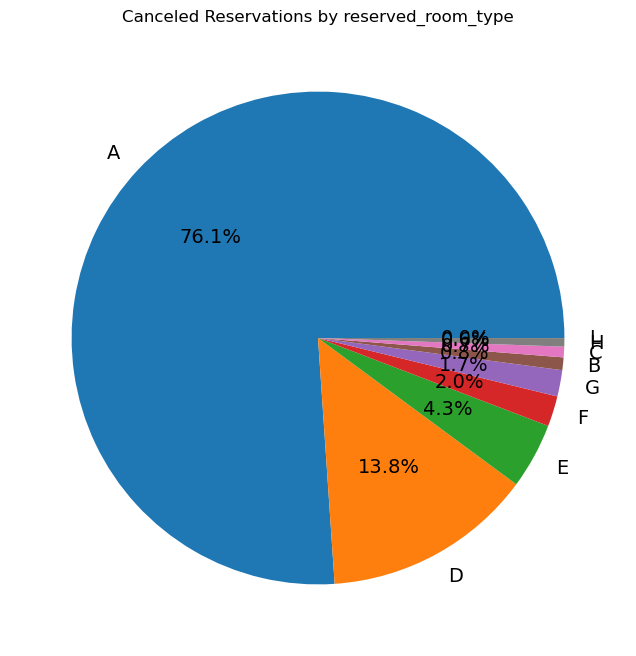

Factor:  lead_time_level 
 very_high    37.4
high         28.6
low          24.1
very_low     10.0
Name: lead_time_level, dtype: float64 



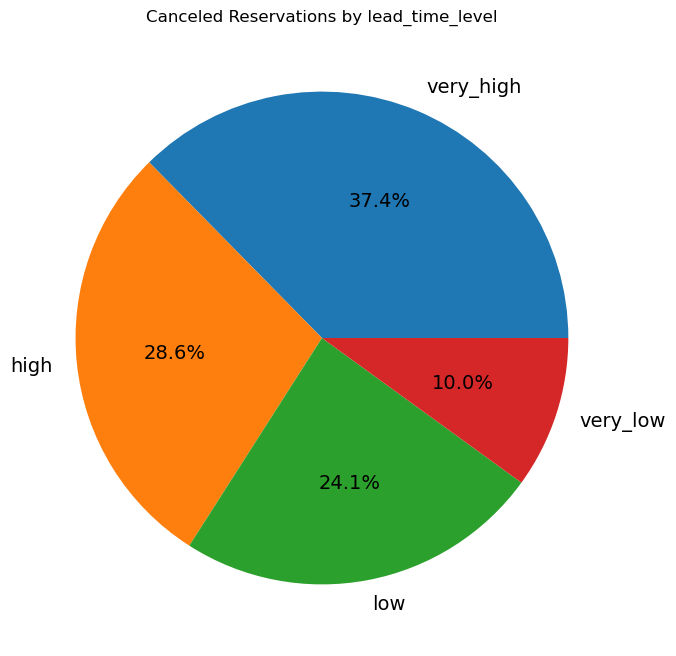

Factor:  deposit_type 
 No Deposit    67.1
Non Refund    32.8
Refundable     0.1
Name: deposit_type, dtype: float64 



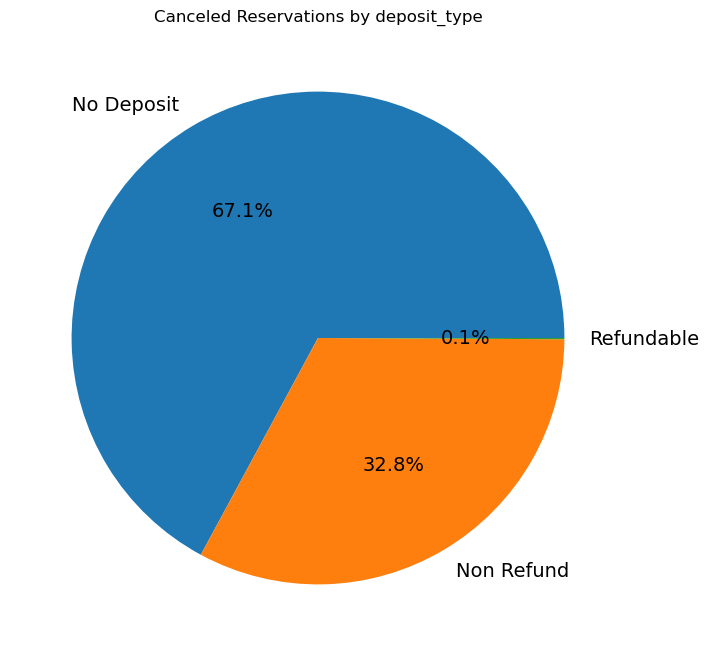

In [21]:
factors = ['hotel', 'family', 'reserved_room_type', 'lead_time_level', 'deposit_type']

for factor in factors:
    plt.rcParams['figure.figsize'] = [8, 8]
    cancel_breakdown = df[df['is_canceled']==1][factor].value_counts(normalize=True) * 100
    print('Factor: ', factor, '\n', round(cancel_breakdown,1), '\n')
    plt.pie(cancel_breakdown, labels=cancel_breakdown.index, autopct='%1.1f%%', textprops={'fontsize': 14})
    plt.title(f'Canceled Reservations by {factor}')
    plt.show()

### Findings
- Cancellations are more common in city hotels than resort hotels.
- Non-family trips have higher cancellation rates.
- Room type A, which accommodates fewer guests, has a higher cancellation rate.
- Longer lead times are associated with higher cancellation rates.
- Reservations made without pre-payment have a higher cancellation rate than non-refundable or refundable reservations.

## 3. Insights related to the relationship between Lead Time and Reservation Cancellations 

### What is the difference of lead time distribution between confirmed reservations and canceled reservations?

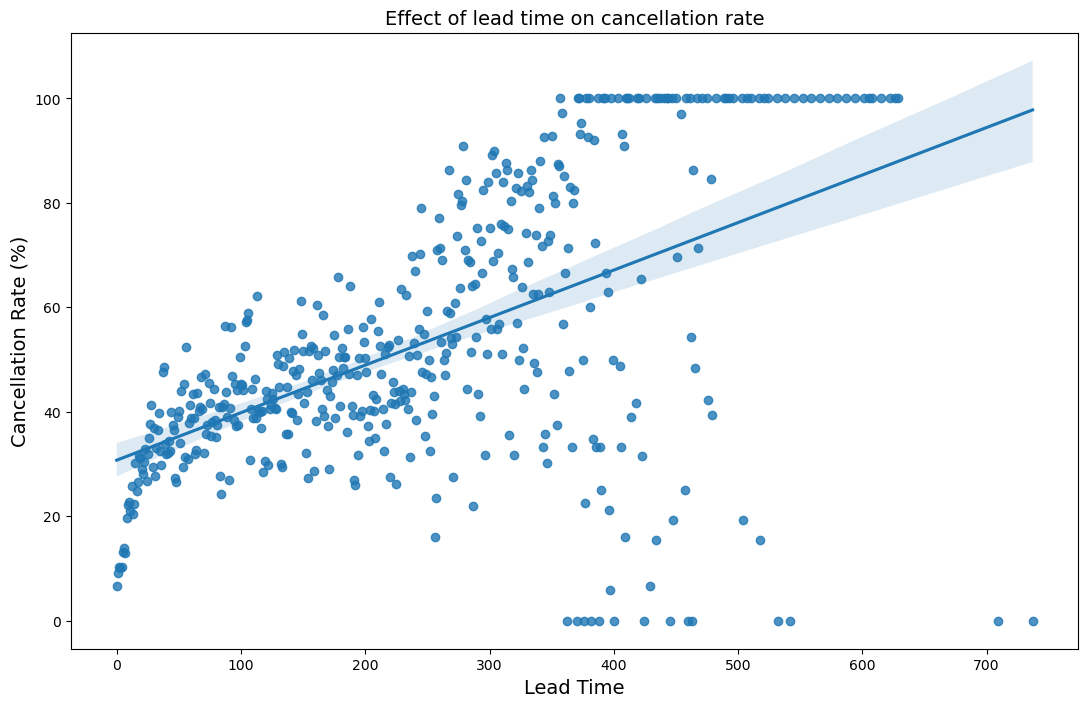

In [22]:
# Group data for lead_time
lead_cancel_data = df.groupby('lead_time')['is_canceled'].mean()

# Plot
plt.figure(figsize=(13, 8))
sns.regplot(x=lead_cancel_data.index, y=lead_cancel_data.values * 100)
plt.title('Effect of lead time on cancellation rate', fontsize=14)
plt.xlabel('Lead Time', fontsize=14)
plt.ylabel('Cancellation Rate (%)', fontsize=14)
plt.show()

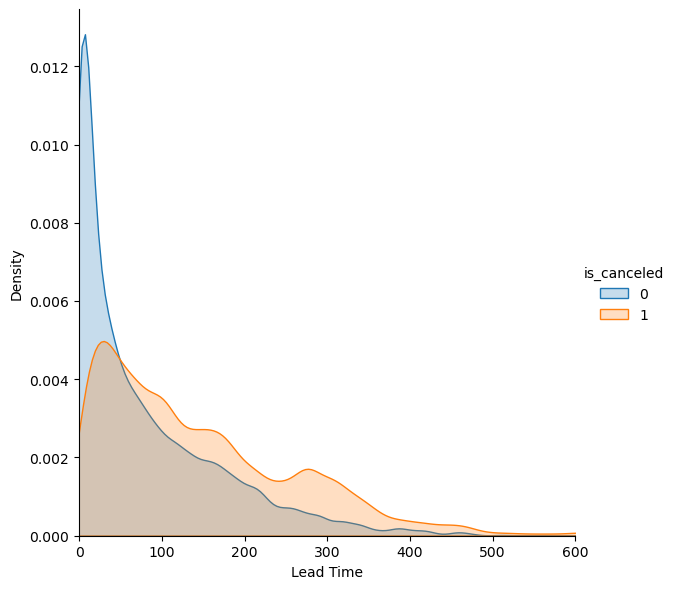

In [23]:
# Plot
grid = sns.FacetGrid(data=df, hue='is_canceled', height=6, xlim=(0, 600))
grid.map(sns.kdeplot, 'lead_time', fill=True)

# Format
grid.add_legend()
grid.set_axis_labels('Lead Time','Density') 

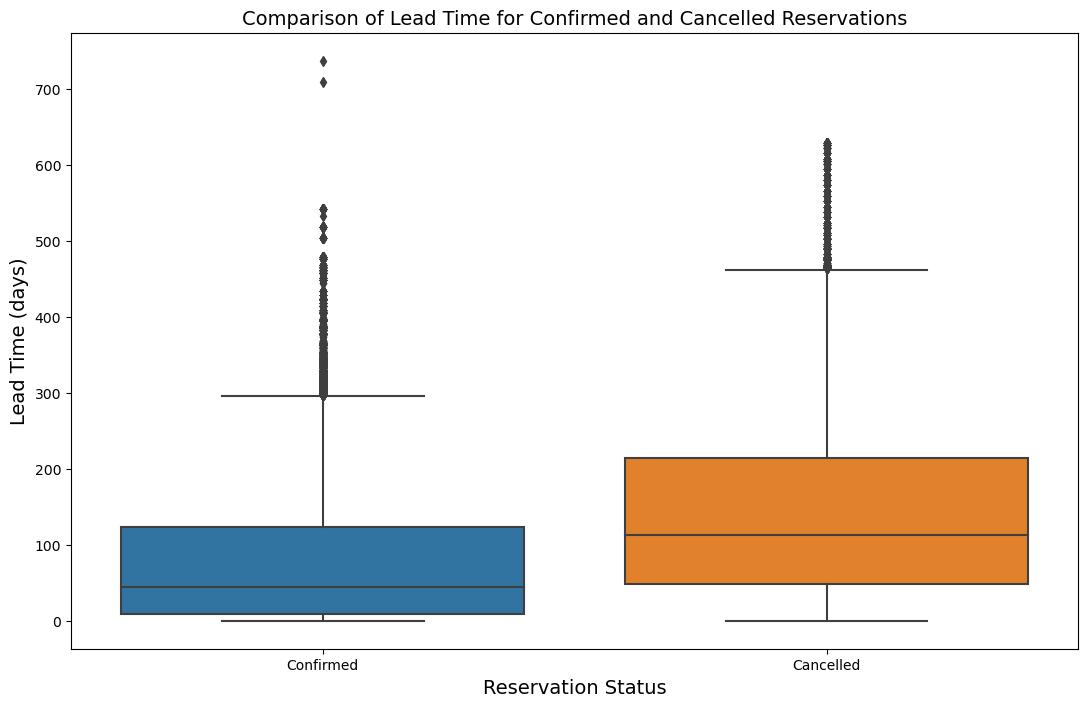

In [24]:
# Create a new column indicating whether the reservation was confirmed or cancelled
df['status'] = df['is_canceled'].apply(lambda x: 'Cancelled' if x == 1 else 'Confirmed')

# Plot
plt.figure(figsize=(13,8))
sns.boxplot(x='status', y='lead_time', data=df)

# Format
plt.xlabel('Reservation Status', fontsize=14)
plt.ylabel('Lead Time (days)', fontsize=14)
plt.title('Comparison of Lead Time for Confirmed and Cancelled Reservations', fontsize=14)
plt.show()

### Findings
- Longer lead times tend to result in higher cancellation rates.
- Encouraging shorter lead times may decrease cancellations.
- The average lead time for cancelled reservations is double that of stayed reservations.
- Shorter lead times may discourage customers from cancelling their reservations as they are less likely to find better options later.

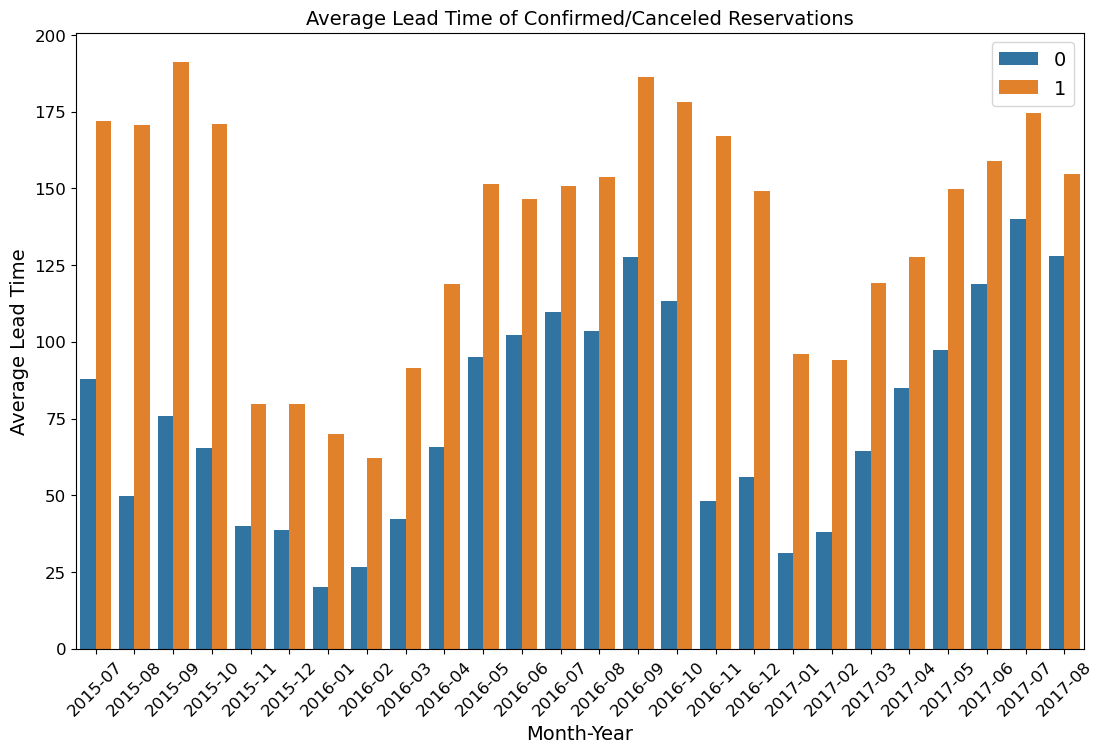

In [25]:
# Compute number of confirmed/canceled reservations
bar = df.groupby(['is_canceled', 'month_year'])['lead_time'].mean().reset_index()

# Plot
plt.figure(figsize=(13,8))
sns.barplot(x=bar.month_year, y=bar.lead_time, hue=bar.is_canceled)

# Format
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Average Lead Time', fontsize=14)
plt.title('Average Lead Time of Confirmed/Canceled Reservations', fontsize=14)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=14)
plt.show()

### Findings
- Across all months, the average lead time for canceled reservations is consistently higher compared to confirmed reservations.
- One possible strategy to decrease the cancellation rate could be to decrease the average lead time each month.

### Canceled reservations 

In [26]:
df[df['is_canceled']==1]['lead_time'].mean()

144.81651313853746

In [27]:
# >144 days before arrival
df[(df['lead_time']>144)]['market_segment'].value_counts()

Online TA        11914
Groups           10709
Offline TA/TO     9765
Direct            1522
Corporate          101
Complementary        5
Name: market_segment, dtype: int64

### Confirmed reservations 

In [28]:
df[df['is_canceled']==0]['lead_time'].mean()

80.08202796923118

In [29]:
# <80 days before arrival
df[df['lead_time']<80]['market_segment'].value_counts()

Online TA        33342
Offline TA/TO     9680
Direct            9584
Groups            5443
Corporate         4898
Complementary      700
Aviation           235
Undefined            2
Name: market_segment, dtype: int64

### Last minute reservations 

In [30]:
# On day of arrival/ 1 day before arrival
df[(df['lead_time']==0)|(df['lead_time']==1)]['market_segment'].value_counts()

Online TA        3735
Direct           3570
Corporate        1144
Offline TA/TO     801
Complementary     282
Groups            113
Aviation           63
Undefined           1
Name: market_segment, dtype: int64

### Findings
- Most customers who cancel are from the Online TA and group segments, due to the ease of doing so through online platforms. Group customers tend to make bulk reservations early on, giving them more flexibility to change their plans. Cancellation also in bulk.
- Customers who do not cancel are mainly from the Online TA and Offline TA/TO segments.
- Customers who book late (on the day of arrival or one day before) are mostly from the Online TA or Direct segments, due to frequently changing plans.
- To reduce cancellations, one strategy could be to offer last-minute deals and discounts to encourage Online TA customers who book early to book later with a lower lead time.

### What is trend of number of staying nights for confirmed and canceled reservations?

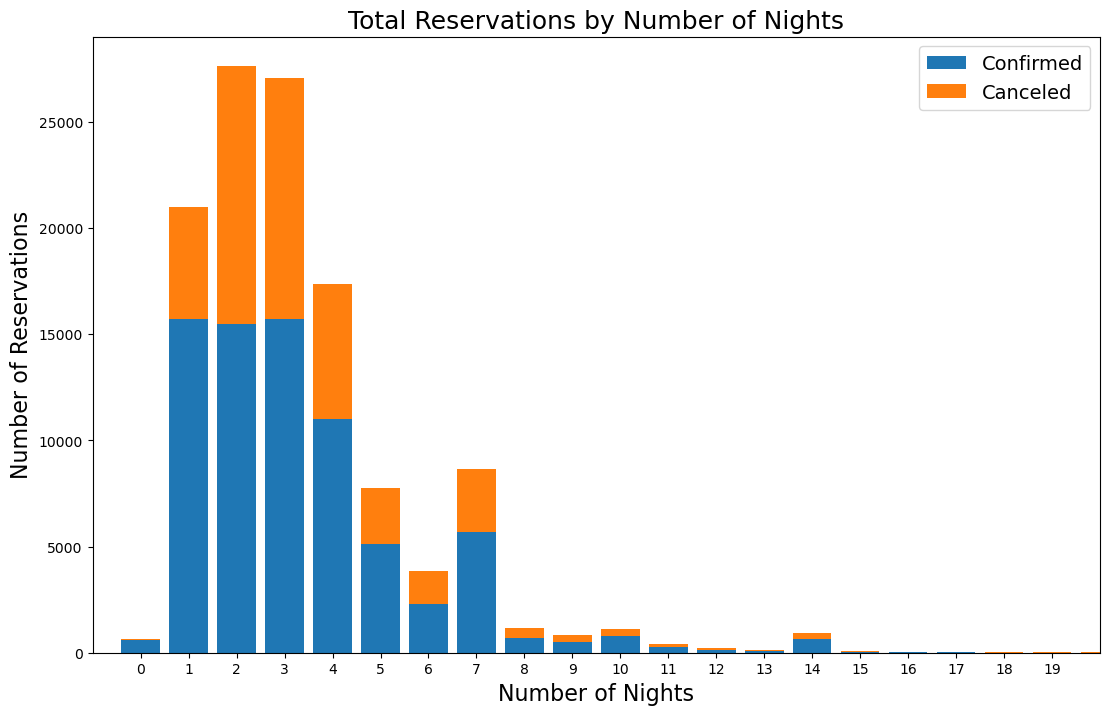

In [31]:
# Compute number of confirmed/canceled reservations
confirmed = df[df['is_canceled']==0].groupby(['total_stay_nights'])['is_canceled'].size()
canceled = df[df['is_canceled']==1].groupby(['total_stay_nights'])['is_canceled'].size()

# Combine the two series into a single dataframe
df_res = pd.DataFrame({'Confirmed': confirmed, 'Canceled': canceled})

# Plot
plt.figure(figsize=(13,8))
for i, column in enumerate(df_res.columns):
    plt.bar(df_res.index, df_res[column], bottom=df_res[df_res.columns[:i]].sum(axis=1), label=column)

# Format
plt.xlabel('Number of Nights', fontsize='16')
plt.ylabel('Number of Reservations', fontsize='16')
plt.title('Total Reservations by Number of Nights', fontsize=18)
plt.legend(fontsize=14)
plt.legend(fontsize=14, bbox_to_anchor=(1, 1))
plt.xlim(-1,20)
plt.xticks(np.arange(0, 20, step=1))
plt.show()


### Findings
- Customers with reservations for 2-3 nights have a higher likelihood of canceling their bookings.

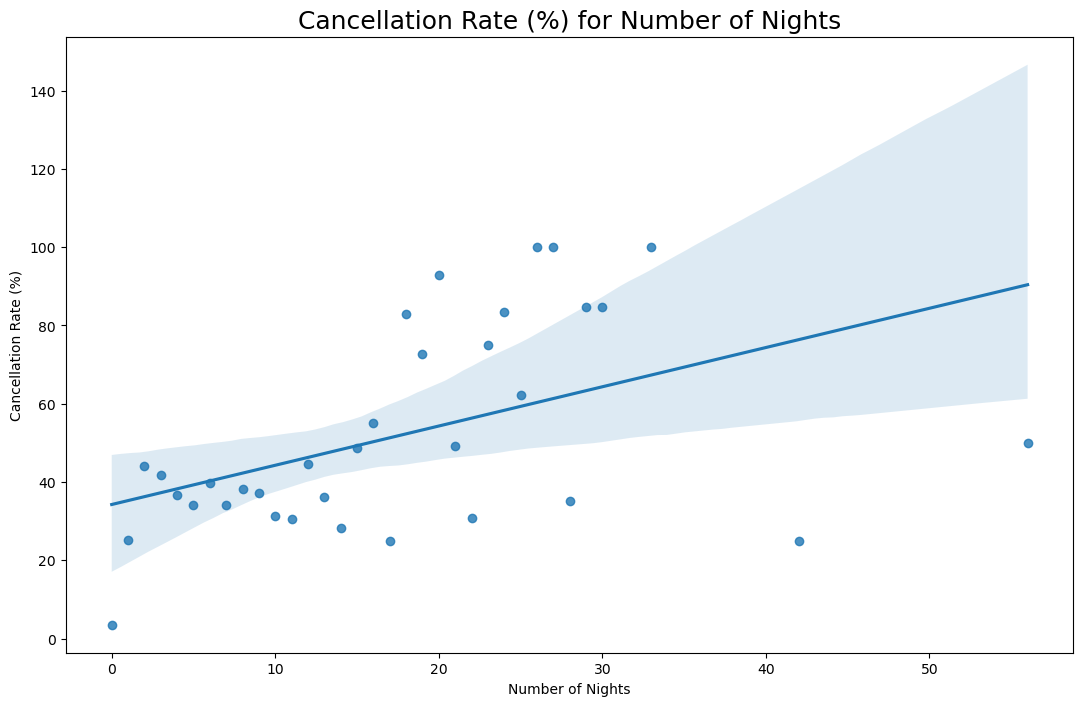

In [32]:
# Calculate the cancellation rate by number of nights
cancel_rate = (df[df['is_canceled']==1].groupby('total_stay_nights').size()) / (df.groupby('total_stay_nights').size()) * 100

# Convert the series to a DataFrame
df_cancel_rate = pd.DataFrame(cancel_rate).reset_index().rename(columns={0: 'cancellation_rate'})

# Create a line chart to visualize the data
plt.figure(figsize=(13,8))
sns.regplot(x='total_stay_nights', y='cancellation_rate', data=df_cancel_rate)
plt.xlabel('Number of Nights')
plt.ylabel('Cancellation Rate (%)')
plt.title('Cancellation Rate (%) for Number of Nights', fontsize=18)
plt.show()

#### Findings
- The data suggests that as the length of a stay increases, the likelihood of cancellation also increases. 
- This correlation could be attributed to the fact that customers who book longer stays may have more flexibility to change their plans or it could be a result of the limited number of reservations made for longer stays, making a higher cancellation rate for these reservations more impactful in proportion.

### Whats customers nationality with highest reservations number has the highest cancellation rate?

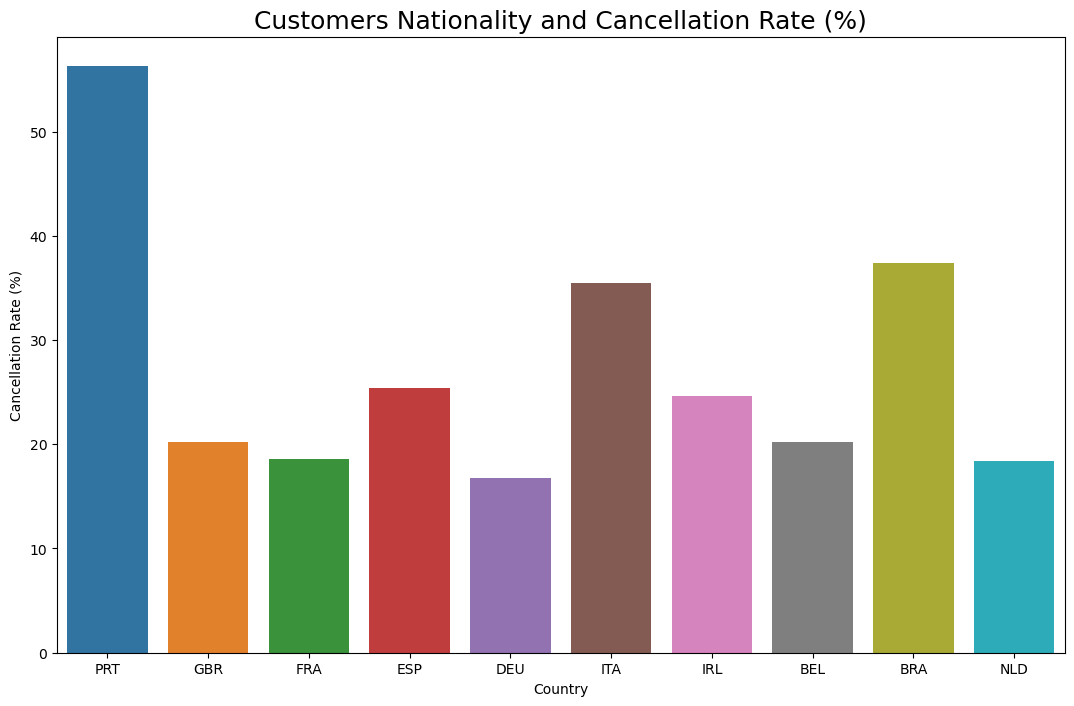

In [33]:
cancelled_reservations_by_country = df[df['is_canceled']==1].groupby(['country']).size()
total_reservations_by_country = df.groupby(['country']).size()

cancellation_rate = cancelled_reservations_by_country / total_reservations_by_country * 100
df_cancellation_rate = pd.DataFrame({'country': total_reservations_by_country.index, 'cancellation_rate': cancellation_rate}).reset_index(drop=True)
df_cancellation_rate = df_cancellation_rate.merge(pd.DataFrame({'country': total_reservations_by_country.index, 'total_reservation': total_reservations_by_country.values}).reset_index(drop=True), on='country', how='left')

#sort by number of reservations
df_cancellation_rate = df_cancellation_rate.sort_values(by='total_reservation', ascending=False)

#Select top 10 countries with the most reservations
top_10 = df_cancellation_rate.head(10)

plt.figure(figsize=(13,8))
sns.barplot(data=top_10, x='country', y='cancellation_rate')
plt.xlabel('Country')
plt.ylabel('Cancellation Rate (%)')
plt.title('Customers Nationality and Cancellation Rate (%)', fontsize=18)
plt.show()


#### Findings
- Portugal has the highest cancellation rate among customers, followed by Brazil, Italy, and Spain, which is more than 30%.
- To decrease the cancellation rate, it may be helpful to tailor the strategies based on specific country markets.

### Who have tendency to cancel last minutes?

### Cancellation on same day or 1 day before arrival

In [34]:
df['arrival_datetime'] = pd.to_datetime(df['arrival_datetime'])
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])
df['days_difference'] = (df['arrival_datetime'] - df['reservation_status_date']).dt.days

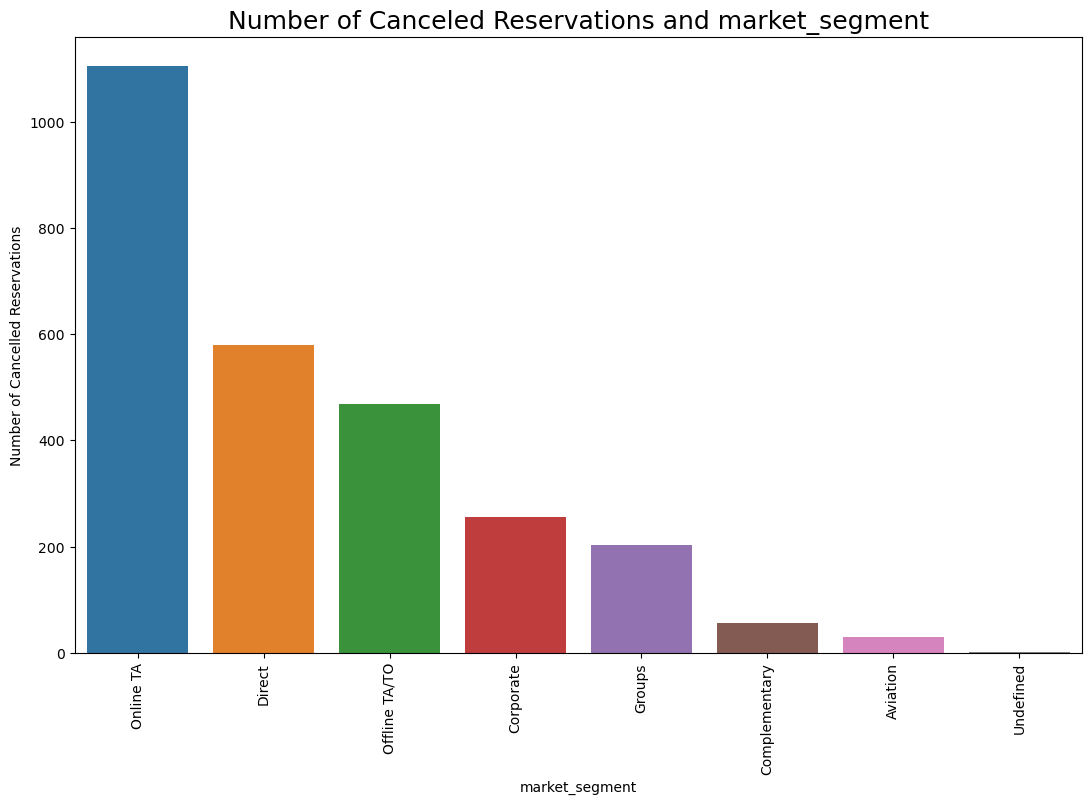

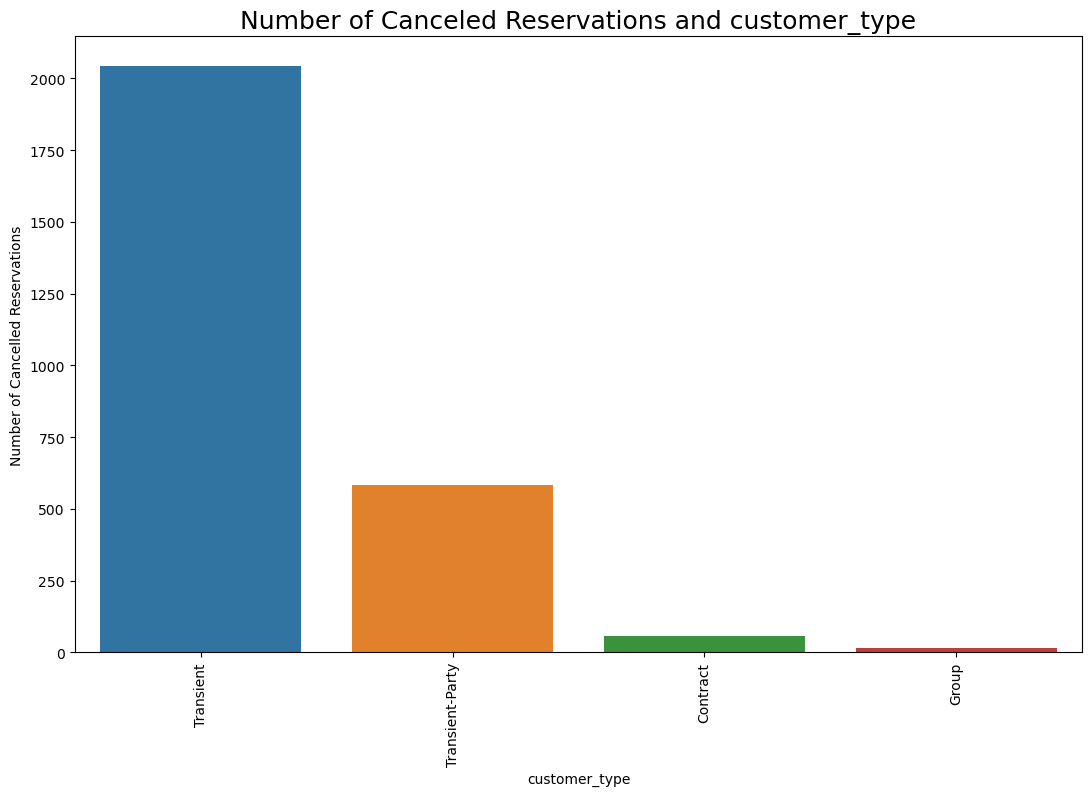

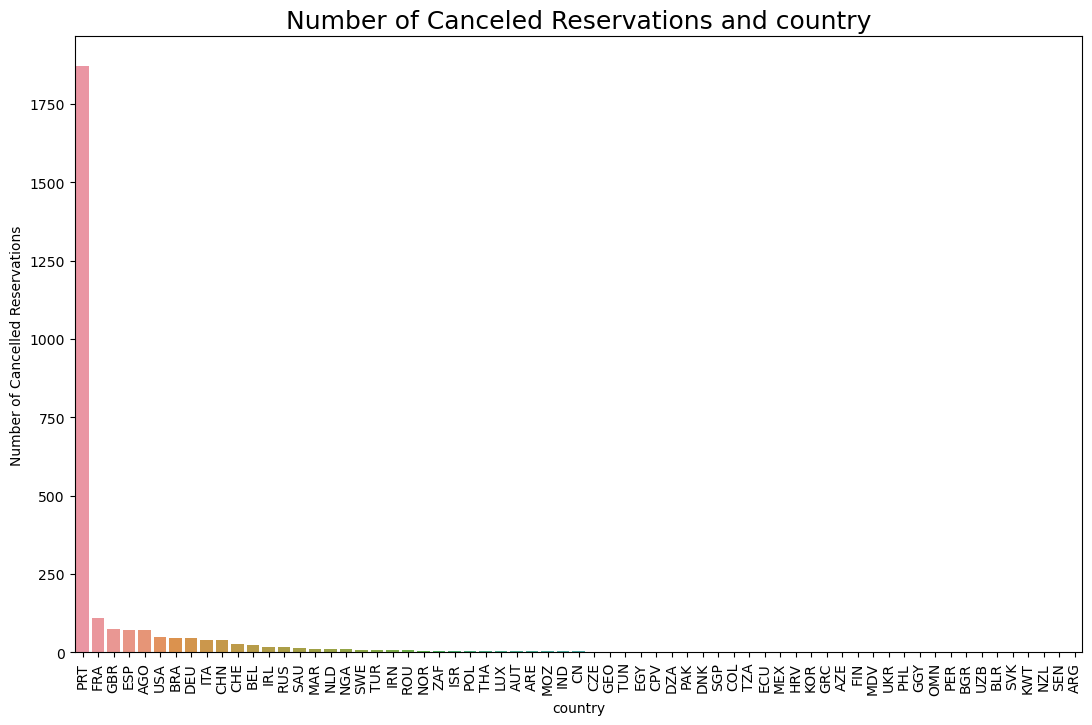

In [35]:
features = ['market_segment', 'customer_type', 'country']
list_dd = [0,1]

for feat in features:
    # Plot
    plt.figure(figsize=(13,8))
    sns.countplot(data=df[(df['days_difference'].isin(list_dd)) & (df['is_canceled']==1)], x=feat, 
                  order=df[(df['days_difference'].isin(list_dd)) & (df['is_canceled']==1)][feat].value_counts().index)
    
    # Format
    plt.xlabel(feat)
    plt.xticks(rotation=90)
    plt.ylabel('Number of Cancelled Reservations')
    plt.title(f'Number of Canceled Reservations and {feat}', fontsize=18)
    plt.show()

#### Findings
- Portugal has the highest instances of last minute cancellations.
- Given the hotel is located in Portugal, it is easier for customers to cancel their reservations at the last minute.
- If these last minute cancellations can be prevented, the hotel would have ample time to fill the rooms with new guests, which will improve the occupancy.

## Conclusion

### Idea on using ML to solve identified issues
1. Use a clustering model to categorize reservations into distinct groups based on their features, enabling us to target specific actions for each group.
    - For instance, group labeling can help us recognize reservations with similar attributes such as high lead time, frequent requests, or a history of cancellations.
    - Targeted actions, tailored for each group, can be more cost-effective and result-oriented.
    - Offer personalized promotions for groups, for instance, transient customers with a high risk of canceling can be given last-minute deals or discounts to change their behavior and prevent early bookings likely to be canceled.
    - Identify the group of reservations likely to cancel last minute and reach out to them with messages promoting other room offers or discounts.
2. Use a classification model to predict if a reservation will be canceled or not, so that we can take early action on reservations likely to be canceled.
    - For example, create a list of customers highly likely to cancel reservations.
    - Take preventive and personalized action by offering discounts or coupons or proactively asking customers if they need any special requests.
3. Use a regression model to predict the number of booking nights for new reservations for optimizing business operation or sales.  
    - Provide insight into expected revenue for new reservations.
    - Use information to optimize pricing strategies and improve sales and marketing efforts.
    - Better predict future demand, hotels can ensure adequate staffing and inventory levels to meet customer needs and maximize revenue.